In [3]:
"""
directory structure

backtracer.ipynb
kabu_plus/
 |- japan-all-stock-data/                            # 07_投資指標データ
    |- daily/
       |- japan-all-stock-data_20210301.csv
       |- *.csv
       ...
 |- japan-all-stock-prices-2/                        # 02_株価一覧表（詳細フォーマット）
    |- daily/
       ...
 |- tosho-stock-ohlc/                                # 06_株価四本値データ（日通し・前場・後場）
    |- daily/
       ... 
 |- japan-all-stock-margin-transactions/             # 10_信用取引残高データ
    |- weekly/
       ... 
"""

base_filepath = 'kabu_plus/'

all_stock_data_filepath = 'japan-all-stock-data/daily/'
japan_all_stock_prices_2_filepath = 'japan-all-stock-prices-2/daily/'
tosho_stock_ohlc_filepath = 'tosho-stock-ohlc/daily/'

japan_all_stock_margin_transactions_filepath = 'japan-all-stock-margin-transactions/weekly/'

In [4]:
import glob
    
def get_all_filename_list(topic_filepath):
    return glob.glob(base_filepath + topic_filepath + "*")

In [67]:
import pandas as pd
from tqdm import tqdm
from datetime import datetime
import mplfinance as mpf

def create_dataframe_from(file_list):
    df = pd.DataFrame()
    for file in tqdm(file_list):
        df_tmp = pd.read_csv(file, encoding="shift-jis")
        
        try:
            dtime = file.split('.')[0][-8:]
            df_tmp['datetime'] = datetime.strptime(dtime, '%Y%m%d')
        except:
            print(file + " has failed to be read")
            continue
        
        df = pd.concat([df, df_tmp])
    return df

In [68]:
def create_sc_datetime_column(file_list):
    def convert_to_numeric_dtype(df, key):
        try:
            df[key] = df.apply(lambda x: float(x[key]), 1)
            df[key] = df[key].apply(pd.to_numeric)        
        except:
            pass
        return df
    df = create_dataframe_from(file_list)
    df = df.sort_values(by=["datetime", "SC"])
        
    # library使用のためrename
    df = df.rename(columns={'高値': 'High', '安値': 'Low', '始値': 'Open', '終値': 'Close', '出来高': 'Volume'})
    
    df = convert_to_numeric_dtype(df, 'High')
    df = convert_to_numeric_dtype(df, 'Low')
    df = convert_to_numeric_dtype(df, 'Open')
    df = convert_to_numeric_dtype(df, 'Close')
    
    key = 'EPS（予想）'
    df[key] = df[key].replace('-', np.nan)    
    df = convert_to_numeric_dtype(df, key)
    
    key = 'BPS（実績）'
    df[key] = df[key].replace('-', np.nan)
    df = convert_to_numeric_dtype(df, key)
    
    key = 'PBR（実績）'
    df[key] = df[key].replace('-', np.nan)
    df = convert_to_numeric_dtype(df, key)
    
    key = 'PER（予想）'
    df[key] = df[key].replace('-', np.nan)
    df = convert_to_numeric_dtype(df, key)
    
    # indexを銘柄+datetimeに変更 (ユニークにする)
    df = df.reset_index()
    df = df.drop(columns=["index"])
    df['SC_datetime'] = df.apply(lambda x: str(x['SC']) + "_" + str(x['datetime']), 1)
    df = df.set_index('SC_datetime')
    return df

In [69]:
file_list = get_all_filename_list(all_stock_data_filepath)

df = create_sc_datetime_column(file_list)

100%|██████████| 265/265 [00:40<00:00,  6.47it/s]


        SC             名称    市場     業種 時価総額（百万円）     発行済株式数 配当利回り（予想）  \
0        1  日経平均株価（日経225）    東証   株価指数         -          -         -   
1        2  TOPIX（東証株価指数）    東証   株価指数         -          -         -   
2     1301             極洋  東証一部  水産・農林     33277   10928283       2.3   
3     1332           日本水産  東証一部  水産・農林    161839  312430277      1.64   
4     1333         マルハニチロ  東証一部  水産・農林    133854   52656910      1.57   
...    ...            ...   ...    ...       ...        ...       ...   
3873  9993           ヤマザワ  東証一部     小売     18042   10960825      1.64   
3874  9994            やまや  東証一部     小売     27716   10847870      1.88   
3875  9995          グローセル  東証一部     卸売     11601   26426800      2.73   
3876  9996          サトー商会   JQS     卸売     12814    9152640      2.14   
3877  9997           ベルーナ  東証一部     小売     70988   97244472       2.6   

     1株配当（予想） PER（予想） PBR（実績） EPS（予想）  BPS（実績）   最低購入額  単元株      高値日付 年初来高値  \
0           -       -       -       -       

In [70]:
file_list = get_all_filename_list(japan_all_stock_prices_2_filepath)

df_prices = create_sc_datetime_column(file_list)

100%|██████████| 265/265 [03:08<00:00,  1.40it/s]


        SC             名称    市場     業種        日付       株価     前日比  前日比（％）  \
0        1  日経平均株価（日経225）    東証   株価指数  20210301  29663.5  697.49    2.41   
1        2  TOPIX（東証株価指数）    東証   株価指数  20210301  1902.48   37.99    2.04   
2     1301             極洋  東証一部  水産・農林  20210301     3045   40.00    1.33   
3     1332           日本水産  東証一部  水産・農林  20210301      518   11.00    2.17   
4     1333         マルハニチロ  東証一部  水産・農林  20210301     2542   78.00    3.17   
...    ...            ...   ...    ...       ...      ...     ...     ...   
3873  9993           ヤマザワ  東証一部     小売  20220329     1646   27.00    1.67   
3874  9994            やまや  東証一部     小売  20220329     2555    3.00    0.12   
3875  9995          グローセル  東証一部     卸売  20220329      439   -1.00   -0.23   
3876  9996          サトー商会   JQS     卸売  20220329     1400    5.00    0.36   
3877  9997           ベルーナ  東証一部     小売  20220329      730   18.00    2.53   

          前日終値        始値  ... 時価総額（百万円）  値幅下限  値幅上限      高値日付 年初来高値 年初来高値乖離

In [71]:
file_list = get_all_filename_list(tosho_stock_ohlc_filepath)

df_ohlc = create_sc_datetime_column(file_list)

100%|██████████| 265/265 [00:44<00:00,  5.90it/s]


        SC        日付    始値    高値    安値    終値       VWAP      出来高       売買代金  \
0     1301  20210301  3005  3060  3005  3045       3033    23000   69759000   
1     1332  20210301   511   519   505   518   514.1017  1510900  776756300   
2     1333  20210301  2484  2549  2469  2542  2521.4544   217200  547659900   
3     1352  20210301   988   988   974   988   984.5882     1700    1673800   
4     1375  20210301  1769  1824  1768  1820  1805.8234   141000  254621100   
...    ...       ...   ...   ...   ...   ...        ...      ...        ...   
3768  9993  20220329  1619  1646  1607  1646  1632.9275     6900   11267200   
3769  9994  20220329  2522  2558  2522  2555  2536.9477   103300  262066700   
3770  9995  20220329   440   440   435   439   437.8527   186000   81440600   
3771  9996  20220329  1395  1400  1394  1400  1395.3333     1200    1674400   
3772  9997  20220329   718   731   711   730    721.597   427800  308699200   

      前場始値  前場高値  前場安値  前場終値  後場始値  後場高値  後場安値  後場終

In [72]:
file_list = get_all_filename_list(japan_all_stock_margin_transactions_filepath)

df_margin = create_sc_datetime_column(file_list)

100%|██████████| 56/56 [00:01<00:00, 46.44it/s]


        SC   信用買残高 信用買残高 前週比    信用売残高 信用売残高 前週比   貸借倍率   datetime
0     1301   24200     +5500    14100     +5500   1.72 2021-03-02
1     1332  897400    -66600   257300    +43600   3.49 2021-03-02
2     1333   95900     -1300    42700    +18500   2.25 2021-03-02
3     1352   11800      -300      300         -  39.33 2021-03-02
4     1375  228400    -15200        -         -      - 2021-03-02
...    ...     ...       ...      ...       ...    ...        ...
3875  9993    1100      +300      600      -100   1.83 2022-03-29
3876  9994   12100     +7300   210400    +83200   0.06 2022-03-29
3877  9995  296100      +800  1127100   +150500   0.26 2022-03-29
3878  9996    1400     -1400        -         -      - 2022-03-29
3879  9997  574600     -9900   623800   +144800   0.92 2022-03-29

[215606 rows x 7 columns]


In [83]:
import numpy as np
key = 'EPS（予想）'
df[key] = df[key].replace('-', np.nan)
df[key] = df[key].apply(pd.to_numeric)

In [84]:
key = 'BPS（実績）'
df[key] = df[key].replace('-', np.nan)
df[key] = df[key].apply(pd.to_numeric)

In [85]:
# 自己資本比率
# ROE = EPS（一株当たり利益）÷ BPS（一株当たり純資産）× 100
# https://www.nomura.co.jp/terms/english/r/roe.html

df['ROE'] = df['EPS（予想）'] / df['BPS（実績）'] * 100

In [87]:
delete_columns = ['SC', '市場', 'datetime']

# 重複column　の排除
df = pd.merge(df.drop(columns=delete_columns), df_ohlc, left_index=True, right_index=True)
df

,名称,業種,時価総額（百万円）,発行済株式数,配当利回り（予想）,1株配当（予想）,PER（予想）,PBR（実績）,EPS（予想）,BPS（実績）,...,売買代金,前場始値,前場高値,前場安値,前場終値,後場始値,後場高値,後場安値,後場終値,datetime
SC_datetime,,,,,,,,,,,,,,,,,,,,,
1301_2021-03-01 00:00:00,極洋,水産・農林,33277,10928283,2.3,70,10.91,0.85,279.01,3570.06,...,69759000,3005,3045,3005,3035,3040,3060,3025,3045,2021-03-01
1332_2021-03-01 00:00:00,日本水産,水産・農林,161839,312430277,1.64,8.5,14.02,0.98,36.96,529.68,...,776756300,511,514,505,512,512,519,511,518,2021-03-01
1333_2021-03-01 00:00:00,マルハニチロ,水産・農林,133854,52656910,1.57,40,20.9,0.94,121.62,2693.94,...,547659900,2484,2498,2469,2497,2491,2549,2491,2542,2021-03-01
1352_2021-03-01 00:00:00,ホウスイ,卸売,8278,8379000,2.02,20,13.79,1.22,71.65,810.44,...,1673800,988,988,974,974,980,988,980,988,2021-03-01
1375_2021-03-01 00:00:00,雪国まいたけ,水産・農林,72527,39850000,2.31,42,14.22,8.41,127.95,216.31,...,254621100,1769,1797,1768,1794,1793,1824,1791,1820,2021-03-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9993_2022-03-29 00:00:00,ヤマザワ,小売,18042,10960825,1.64,27,35.88,0.62,45.87,2641.08,...,11267200,1619,1619,1607,1610,1644,1646,1621,1646,2022-03-29
9994_2022-03-29 00:00:00,やまや,小売,27716,10847870,1.88,48,6.3,1.02,405.84,2509.49,...,262066700,2522,2554,2522,2547,2547,2558,2540,2555,2022-03-29
9995_2022-03-29 00:00:00,グローセル,卸売,11601,26426800,2.73,12,-,0.49,-23.35,887.37,...,81440600,440,440,435,435,438,439,435,439,2022-03-29


In [296]:
keys = ['PBR（実績）', 'PER（予想）', '時価総額（百万円）']
for key in tqdm(keys):
    df[key] = df[key].replace('-', np.nan) 
    df[key] = df[key].apply(pd.to_numeric)
df[(df['datetime'] == '2021-03-01') & (df['PBR（実績）'] <= 1) & (df['PER（予想）'] <= 30) & (df['時価総額（百万円）'] <= 10000)][['SC']]

100%|██████████| 3/3 [00:05<00:00,  1.83s/it]


,SC
SC_datetime,
1443_2021-03-01 00:00:00,1443
1451_2021-03-01 00:00:00,1451
1718_2021-03-01 00:00:00,1718
1724_2021-03-01 00:00:00,1724
1728_2021-03-01 00:00:00,1728
...,...
9966_2021-03-01 00:00:00,9966
9967_2021-03-01 00:00:00,9967
9972_2021-03-01 00:00:00,9972


In [298]:
stock_num = 1443

In [299]:
df_specific = df[df['SC'] == stock_num]

df_specific = df_specific.reset_index()
df_specific['datetime'] = df_specific.apply(lambda x: datetime.strptime(str(x['datetime']), '%Y-%m-%d %H:%M:%S'), 1)
df_specific = df_specific.set_index('datetime')

df_specific['Open'] = df_specific['Open'].apply(pd.to_numeric)
df_specific['Close'] = df_specific['Close'].apply(pd.to_numeric)        
df_specific['High'] = df_specific['High'].apply(pd.to_numeric)
df_specific['Low'] = df_specific['Low'].apply(pd.to_numeric)
df_specific['Volume'] = df_specific['Volume'].apply(pd.to_numeric)

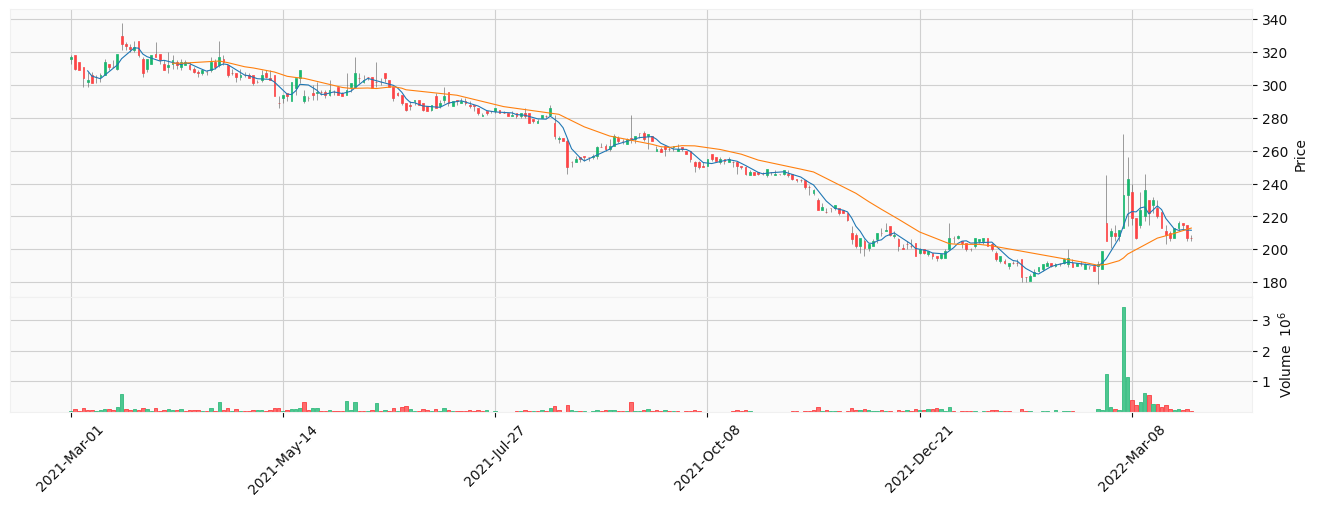

In [302]:
mpf.plot(df_specific, type='candle', volume=True, mav=(5, 25), figratio=(12,4), style='yahoo')

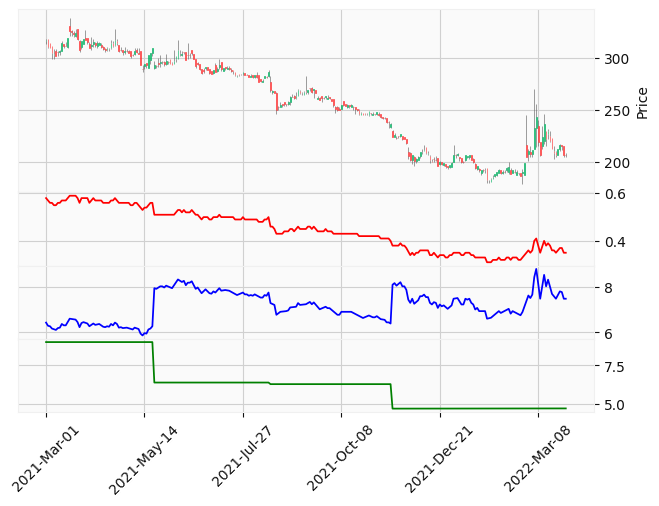

In [311]:
df_specific['PBR（実績）'] = df_specific['PBR（実績）'].apply(pd.to_numeric)
df_specific['PER（予想）'] = df_specific['PER（予想）'].apply(pd.to_numeric)

add_plot_list = [
    mpf.make_addplot(df_specific['PBR（実績）'], color='r', panel=1, secondary_y=False),
    mpf.make_addplot(df_specific['PER（予想）'], color='b', panel=2, secondary_y=False),
    mpf.make_addplot(df_specific['ROE'], color='g', panel=3, secondary_y=False)
]

mpf.plot(df_specific, type='candle', style='yahoo', addplot=add_plot_list)

In [304]:
df_specific[['PBR（実績）', 'PER（予想）', 'ROE']]

,PBR（実績）,PER（予想）,ROE
datetime,,,
2021-03-01,0.58,6.43,9.006489
2021-03-02,0.57,6.29,9.006489
2021-03-03,0.56,6.27,9.006489
2021-03-04,0.56,6.17,9.006489
2021-03-05,0.55,6.15,9.006489
...,...,...,...
2022-03-23,0.36,7.68,4.729488
2022-03-24,0.37,7.79,4.729488
2022-03-25,0.37,7.76,4.729488


In [99]:
df_specific['時価総額（百万円）']

datetime
2021-03-01    10969018
2021-03-02    10842243
2021-03-03    10777880
2021-03-04    10617947
2021-03-05    10772029
                ...   
2022-03-23    13238456
2022-03-24    13220346
2022-03-25    13035624
2022-03-28    13176882
2022-03-29    13289164
Name: 時価総額（百万円）, Length: 265, dtype: object

In [305]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

from backtesting.test import SMA, GOOG

class SmaCross(Strategy):
    n1 = 7
    n2 = 23

    def init(self):
        close = self.data.Close
        self.sma1 = self.I(SMA, close, self.n1)
        self.sma2 = self.I(SMA, close, self.n2)

    def next(self):
        if crossover(self.sma1, self.sma2):
            self.buy()
        elif crossover(self.sma2, self.sma1):
            self.sell()

bt = Backtest(
    df_specific,
    SmaCross,
    cash=1000000, 
    commission=.003,
    exclusive_orders=True
)

output = bt.run()
bt.plot()

print(output)

Start                     2021-03-01 00:00:00
End                       2022-03-29 00:00:00
Duration                    393 days 00:00:00
Exposure Time [%]                   89.811321
Equity Final [$]                  1396464.649
Equity Peak [$]                   1525954.859
Return [%]                          39.646465
Buy & Hold Return [%]              -34.700315
Return (Ann.) [%]                   37.377393
Volatility (Ann.) [%]               41.006177
Sharpe Ratio                         0.911506
Sortino Ratio                        2.069029
Calmar Ratio                         2.523235
Max. Drawdown [%]                  -14.813282
Avg. Drawdown [%]                   -3.712688
Max. Drawdown Duration       99 days 00:00:00
Avg. Drawdown Duration       19 days 00:00:00
# Trades                                    9
Win Rate [%]                        66.666667
Best Trade [%]                      22.845459
Worst Trade [%]                     -5.284148
Avg. Trade [%]                    

In [355]:
class BacktestSimulator:
    def __init__(self, df, initial_amount, commission, pbr_threshold, per_threshold):
        self.df = df
        self.initial_amount = initial_amount
        self.commission = commission
        self.pbr_threshold = pbr_threshold
        self.per_threshold = per_threshold
        
        self.action = None
        self.last_series = None
        self.is_open = True

        self.portforio = {}
        self.total_profit = 0
        
        self.history = []

    def run(self):
        def execute_action(self, series):
            def buy(self, series):
                if self.portforio.get(series['SC']):
                    return None
                if not self.is_open:
                    threshold = series['Open']
                else:
                    threshold = series['Close']
                if self.initial_amount >= threshold:
                    self.portforio[series['SC']] = {
                        "price": threshold, 
                        "SC": series['SC'], 
                        "datetime": series['SC_datetime'].split('_')[1]
                    }
                    self.initial_amount -= threshold
                    self.history.append(
                        {
                            "price": threshold, 
                            "SC": series['SC'], 
                            "datetime": series['SC_datetime'].split('_')[1],
                            "operation": "buy"
                        }
                    )
                    print("bought : " + str(self.portforio.get(series['SC'])))
                else:
                    return None
                
            def sell(self, series):
                if not self.portforio.get(series['SC']):
                    return None
                if not self.is_open:
                    threshold = series['Open']
                else:
                    threshold = series['Close']
                dct = self.portforio.get(series['SC'])
                self.total_profit += threshold - dct['price']
                self.portforio.pop(series['SC'])
                self.history.append(
                    {
                        "price": threshold, 
                        "SC": series['SC'], 
                        "datetime": series['SC_datetime'].split('_')[1],
                        "operation": "sell"
                    }
                )                
                return None
            
            if self.action == "寄成買" or self.action == "引成買":
                buy(self, series)
            elif self.action == "寄成売" or self.action == "引成売":
                sell(self, series)
            else:
                return None
        
        def select_action(self, series):
            if series is None:
                return None
            def satisfy_buy_condition(self, series):
                return series['PBR（実績）'] < self.pbr_threshold and not self.portforio.get(series['SC'])
            
            def satisfy_sell_condition(self, series):
                return series['PBR（実績）'] >= self.pbr_threshold and self.portforio.get(series['SC'])
            
            if not self.is_open:
                if satisfy_buy_condition(self, series):
                    return "寄成買"
                if satisfy_sell_condition(self, series):  
                    return "寄成売"
            else:
                if satisfy_buy_condition(self, series):
                    return "引成買"
                if satisfy_sell_condition(self, series):  
                    return "引成売"
            return None
        
        initial_day = True
        for i, series in self.df.iterrows():
            """
                Market is closed
            """
            self.is_open = False
            
            # initial day will be disabled
            if not initial_day:
                # Get last action and execute
                execute_action(self, self.last_series)

                # 始値で買う, 差し値で買う, 始値で売る, 差し値で売る, 何もしない
                self.action = select_action(self, self.last_series)
                             
                print("Market close action:", self.action)                    
                    
            """
                -- Next day --
            """
            print("datetime : " + str(i))
            """
                Market is open
            """
            self.is_open = True
            # Get last action and execute
            execute_action(self, series)
            
            # 終値で買う, 差し値で買う, 終値で売る, 差し値で売る, 何もしない      
            self.action = select_action(self, series)
            self.last_series = series            
            initial_day = False

            print("Market open action:", self.action)

        """
            Backtest finished
            
            Owning stocks will be sold as latest Close price
        """
        if self.portforio.get(self.last_series['SC']):
            bought_price = self.portforio[self.last_series['SC']]['price']
            sell_price = self.last_series['Close']
            self.total_profit += sell_price - bought_price
            print("sold : " + str(self.last_series['SC']) + ", price : " + str(self.last_series['Close']))
            
            self.history.append(
                    {
                        "price": sell_price, 
                        "SC": self.last_series['SC'], 
                        "datetime": self.last_series['SC_datetime'].split('_')[1],
                        "operation": "sell"
                    }
            )
            
        return {
            "total_profit": self.total_profit
        }
    
    def plot(self):        
        idx = 0
        h = self.history[idx]
        for i, series in self.df.iterrows():
            dtime = datetime.strptime(h['datetime'], '%Y-%m-%d %H:%M:%S')
            if i == dtime:
                if h['operation'] == 'buy':
                    self.df.at[i, 'is_bought'] = h['price']
                else:
                    self.df.at[i, 'is_sold'] = h['price']
                idx += 1
                if idx >= len(self.history):
                    continue
                h = self.history[idx]
                
        buy_plot = mpf.make_addplot(self.df['is_bought'], type='scatter', marker='^', markersize=80, panel=0)
        sell_plot = mpf.make_addplot(self.df['is_sold'], type='scatter', marker='v', markersize=80, panel=0)
        
        add_plot_list = [
            #mpf.make_addplot(self.df['PBR（実績）'], color='r', panel=1, secondary_y=False),
            #mpf.make_addplot(self.df['PER（予想）'], color='b', panel=2, secondary_y=False),
            #mpf.make_addplot(self.df['ROE'], color='g', panel=3, secondary_y=False),
            buy_plot,
            sell_plot
        ]
        
        mpf.plot(self.df, type='candle', style='yahoo', addplot=add_plot_list, volume=True, mav=(5, 25), figratio=(12,4))
        #print(self.history)

datetime : 2021-03-01 00:00:00
Market open action: None
Market close action: None
datetime : 2021-03-02 00:00:00
Market open action: None
Market close action: None
datetime : 2021-03-03 00:00:00
Market open action: None
Market close action: None
datetime : 2021-03-04 00:00:00
Market open action: None
Market close action: None
datetime : 2021-03-05 00:00:00
Market open action: None
Market close action: None
datetime : 2021-03-08 00:00:00
Market open action: None
Market close action: None
datetime : 2021-03-09 00:00:00
Market open action: None
Market close action: None
datetime : 2021-03-10 00:00:00
Market open action: None
Market close action: None
datetime : 2021-03-11 00:00:00
Market open action: None
Market close action: None
datetime : 2021-03-12 00:00:00
Market open action: None
Market close action: None
datetime : 2021-03-15 00:00:00
Market open action: None
Market close action: None
datetime : 2021-03-16 00:00:00
Market open action: None
Market close action: None
datetime : 2021-

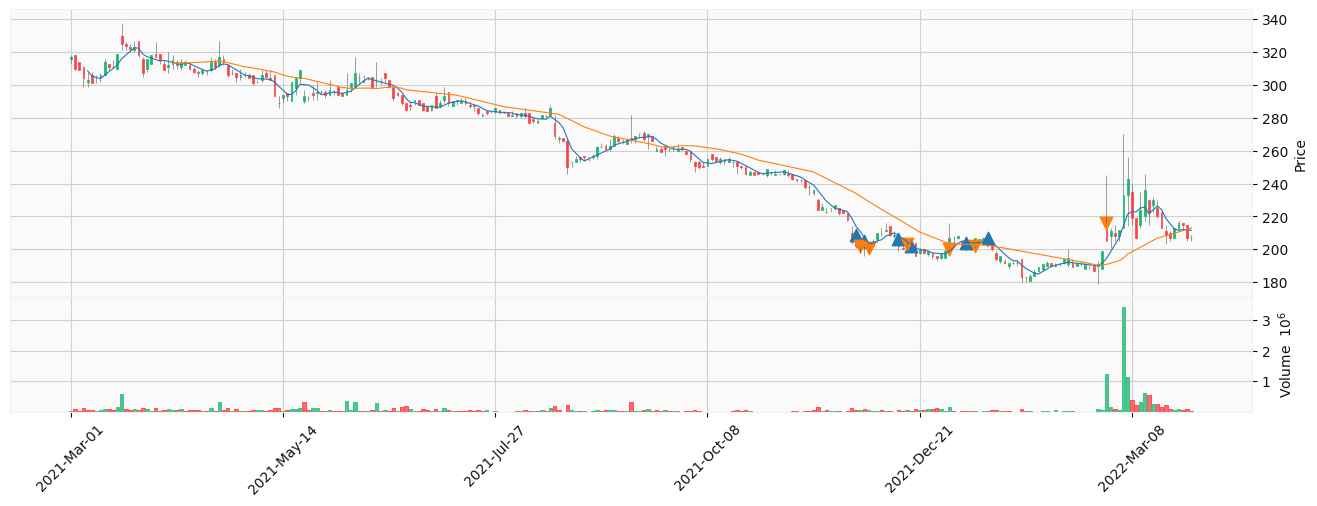

In [356]:
bt = BacktestSimulator(
    df=df_specific,
    initial_amount=10000, 
    commission=.001, # 今つかってない
    pbr_threshold=0.35,
    per_threshold=10 # 今つかってない
)

output = bt.run()
bt.plot()

In [357]:
# 利益: -9 * 100円
print(output)

{'total_profit': -9}
